# Impulse Response Function

In [43]:
library(tidyverse) # readr, ggplot, dplyr, ...
library(gridExtra) # Arrangning ggplots
library(readxl)    # Loading excel
library(repr)      # Resizing the plots in jupyter
library(rugarch)   # For ARCH and GARCH models
library(dynlm)     # Lagged linear models
library(urca)      # Dick Fuller test
library(car)       # Linear hyphothesis testing
library(tseries)   # adf-test
library(vars)      # VAR models
library(zoo)       # Convert quarters to date
library(forecast)  

options(repr.plot.width=5, repr.plot.height=2.5)

## Define usefull function

In [17]:
irf_lars <- function(x) {
    m <- VAR(x, p = 1, type = "const")
    hej <- ncol(x)
    chart_title <- substitute(paste("VAR(1) model with ", hej," variables"))
psim <- as.data.frame(x)
psim$n <- c(1:nsim)
psim <- gather(psim, variable, value, -n)

p1 <- ggplot(psim, aes(n, value, linetype=variable)) + 
 geom_line(color="#045a8d") + 
 labs(title=chart_title, x="", y="")

data <- irf(m, nsteps = 12, n.ahead=20)
variables <- data$irf %>% names

ir <- lapply(1:length(variables), function(e){
    data_to_plot <- data.frame(data %>% `$`(irf) %>% `[[`(variables[e])) %>%
      mutate("t" = 1:NROW(.)) %>%
      gather(.,Variable, Value, -t)

    upper_ci <- data.frame(data %>% `$`(Upper) %>% `[[`(variables[e])) %>%
      mutate("t" = 1:NROW(.)) %>%
      gather(.,Variable, Upper, -t)

    lower_ci <- data.frame(data %>% `$`(Lower) %>% `[[`(variables[e]) ) %>%
      mutate("t" = 1:NROW(.)) %>%
      gather(.,Variable, Lower, -t)

    res <- inner_join(data_to_plot, upper_ci, c("t","Variable")) %>%
           inner_join(.,lower_ci, c("t","Variable")) %>%
           mutate(impulse = paste("Shock to", variables[e])) 
}) %>% bind_rows

p2 <- ggplot(ir, aes(x = t, y = Value, group = Variable))  +
  geom_line(color="#045a8d") +
  geom_ribbon(aes(x=t, ymax=Upper, ymin=Lower), alpha=0.15, fill="#045a8d") +
  scale_x_continuous(limits = c(0,21), breaks = seq(0,20,2)) +
  scale_y_continuous("", position="right") +
  labs(title="Impulse Response Functions", x="") +
  facet_grid(Variable ~ impulse, scales="free", switch="y")

print(p1); print(p2)
}

Important both models are limited in that they contain a identification restriction
$$ e_{1t} = \varepsilon_{yt} - b_{12}\varepsilon_{zt}$$
$$ e_{2t} = \varepsilon_{zt} $$
This means that there is no contemporary effect from $y_t$ to $z_t$ but only the other way round. In effect this is implemented as:
$$ e_{1t} = \varepsilon_{yt} + 0.8\varepsilon_{zt}$$
$$ e_{2t} = \varepsilon_{zt} $$

# First model - positive off-diagonal elements of $A_1$

$$
\begin{bmatrix} y_t \\ z_t \end{bmatrix}
=
\begin{bmatrix} 0.7 & 0.2 \\ 0.2 & 0.7 \end{bmatrix}
\cdot
\begin{bmatrix} y_{t-1} \\ z_{t-1} \end{bmatrix}
+
\begin{bmatrix} e_{1t} \\ e_{2t} \end{bmatrix}
$$

In [45]:
yt <- c(0)
zt <- c(0)
nsim <- 200

for (i in 2:nsim) {
    ey <- rnorm(1)
    ez <- rnorm(1)
    yt[i] <- 0.7*yt[i-1] + 0.2*zt[i-1] + (ey+0.8*ez)
    zt[i] <- 0.7*zt[i-1] + 0.2*yt[i-1] + (ez)
}
sim <- cbind(zt, yt)

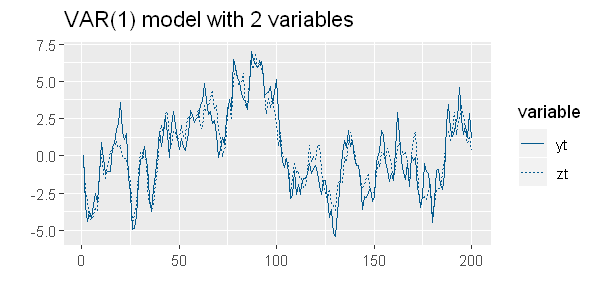

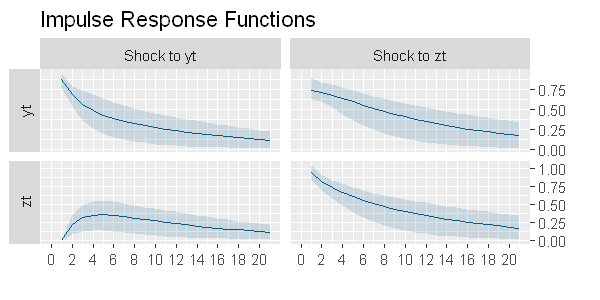

In [46]:
irf_lars(sim)

In [9]:
VAR(sim, p = 1, type = "const")


VAR Estimation Results:

Estimated coefficients for equation zt: 
Call:
zt = zt.l1 + yt.l1 + const 

       zt.l1        yt.l1        const 
 0.740424445  0.131290416 -0.007898239 


Estimated coefficients for equation yt: 
Call:
yt = zt.l1 + yt.l1 + const 

     zt.l1      yt.l1      const 
 0.2505384  0.6572646 -0.0589990 



# Second model - negative off-diagonal elements of $A_1$

$$
\begin{bmatrix} y_t \\ z_t \end{bmatrix}
=
\begin{bmatrix} 0.7 & -0.2 \\ -0.2 & 0.7 \end{bmatrix}
\cdot
\begin{bmatrix} y_{t-1} \\ z_{t-1} \end{bmatrix}
+
\begin{bmatrix} e_{1t} \\ e_{2t} \end{bmatrix}
$$

In [10]:
yt <- c(0)
zt <- c(0)
nsim <- 200

for (i in 2:nsim) {
    ey <- rnorm(1) 
    ez <- rnorm(1)
    yt[i] <- 0.7*yt[i-1] - 0.2*zt[i-1] + (ey + 0.8*ez)
    zt[i] <- 0.7*zt[i-1] - 0.2*yt[i-1] + (ez)
}
sim2 <- cbind(zt, yt)

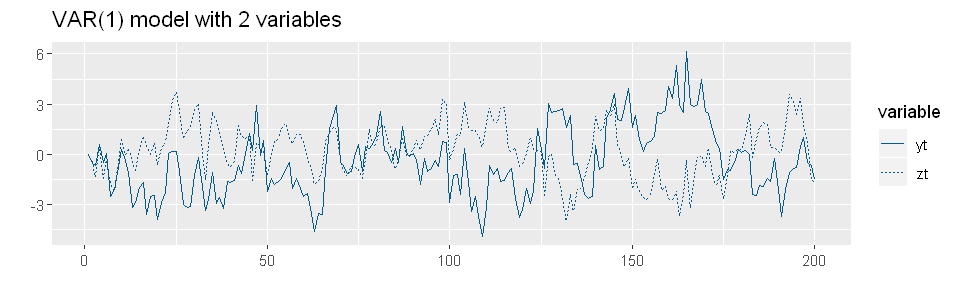

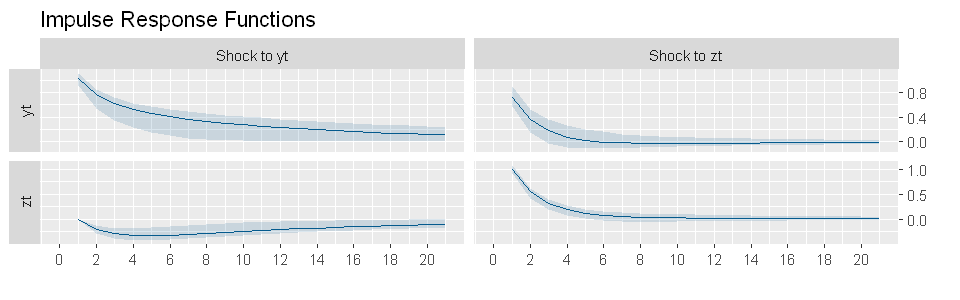

In [11]:
irf_lars(sim2)

In [12]:
VAR(sim2, p = 1, type = "const")


VAR Estimation Results:

Estimated coefficients for equation zt: 
Call:
zt = zt.l1 + yt.l1 + const 

      zt.l1       yt.l1       const 
 0.70175363 -0.19659864 -0.03804027 


Estimated coefficients for equation yt: 
Call:
yt = zt.l1 + yt.l1 + const 

      zt.l1       yt.l1       const 
-0.18112457  0.75775177 -0.08159787 



In [13]:
#m <- VAR(as.ts(sim2), p = 1, type = "const")
#forecast(m) %>% autoplot()

# VAR model with three variables

This could be like this: 

$$
\begin{bmatrix} y_t \\ z_t \\ x_t \end{bmatrix}
=
\begin{bmatrix} 0.5 & 0.2 & 0.1 \\ 0.2 & 0.1 & 0.1 \\ 0.1 & 0.3 & 0.9 \end{bmatrix}
\cdot
\begin{bmatrix} y_{t-1} \\ z_{t-1} \\ x_{t-1} \end{bmatrix}
+
\begin{bmatrix} e_{1t} \\ e_{2t} \\ e_{3t} \end{bmatrix}
$$


First we need to check a system of equations which is stationary

In [14]:
yy=0.5; yz=0.2; yx=0.1
zy=0.2; zz=0.1; zx=0.1
xy=0.1; xz=0.3; xx=0.9

ma <- matrix(c(yy, yz, yx,
               zy, zz, zx,
               xy, xz, xx), nrow=3, byrow=T)
ma

print(Mod(eigen(ma)$values))

0.5,0.2,0.1
0.2,0.1,0.1
0.1,0.3,0.9


[1] 0.981341767 0.516686024 0.001972209


If the values are all within unity we can proceed

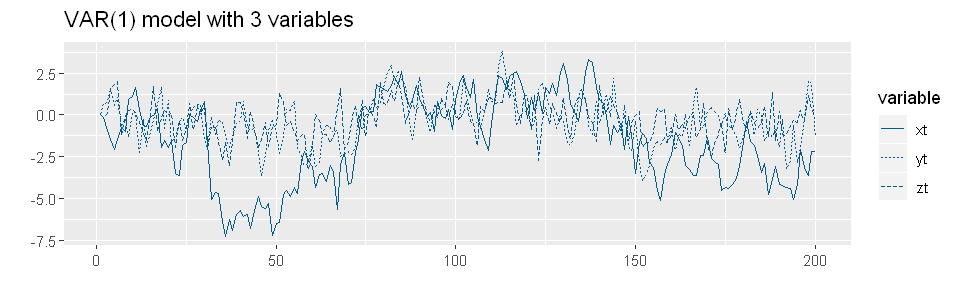

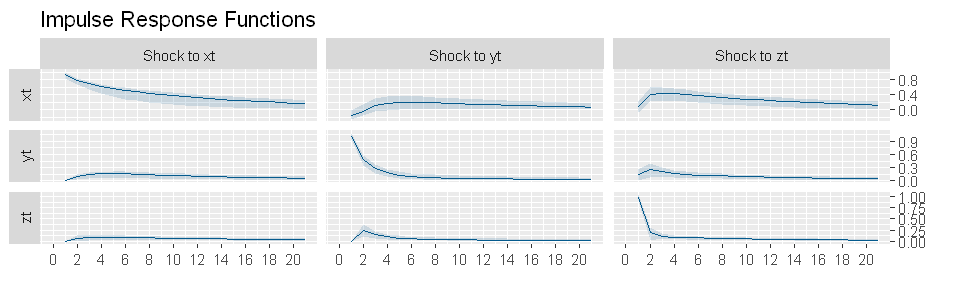

In [15]:
yt <- c(0)
zt <- c(0)
xt <- c(0)
nsim <- 200

for (i in 2:nsim) {
    ey <- rnorm(1) 
    ez <- rnorm(1)
    ex <- rnorm(1)
    yt[i] <- yy*yt[i-1] + yz*zt[i-1] + yx*xt[i-1] + ey
    zt[i] <- zy*yt[i-1] + zz*zt[i-1] + zx*xt[i-1] + ez
    xt[i] <- xy*yt[i-1] + xz*zt[i-1] + xx*xt[i-1] + ex
}
sim <- cbind(zt, yt, xt)

irf_lars(sim)

## How manny lags do the vars package suggest by different selection models?
The answer is by no surprise 1, as we simulates data with 1 lag.

In [16]:
print(VARselect(sim, lag.max=8, type="const")[["selection"]])

AIC(n)  HQ(n)  SC(n) FPE(n) 
     1      1      1      1 


In [17]:
#m <- VAR(as.ts(sim), p = 1, type = "const")
#forecast(m) %>% autoplot()

# SVAR model with three variables
First i calculate the number of restricted paramatres i need

In [18]:
n <- 3
(n^2-n)/2

[1] 3

In [123]:
rm(ey); rm(ex); rm(ez)

yy=0.5; yz=0.0; yx=0.0
zy=0.2; zz=0.1; zx=0.0
xy=0.1; xz=0.3; xx=0.9

ma <- matrix(c(yy, yz, yx,
               zy, zz, zx,
               xy, xz, xx), nrow=3, byrow=T)

print(Mod(eigen(ma)$values))

yt <- c(0)
zt <- c(0)
xt <- c(0)
nsim <- 1000

for (i in 2:nsim) {
    ey <- rnorm(1) 
    ez <- rnorm(1) + 0.7*ey
    ex <- rnorm(1) + 0.7*ey + 0.7*ez
    yt[i] <- yy*yt[i-1] + yz*zt[i-1] + yx*xt[i-1] + ey
    zt[i] <- zy*yt[i-1] + zz*zt[i-1] + zx*xt[i-1] + ez
    xt[i] <- xy*yt[i-1] + xz*zt[i-1] + xx*xt[i-1] + ex
}
sim <- cbind(zt, yt, xt)

[1] 0.9 0.5 0.1


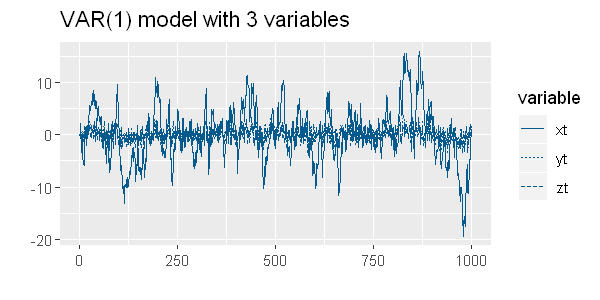

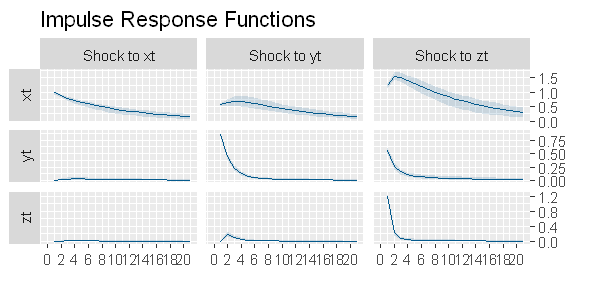

In [124]:
irf_lars(sim)

In [126]:
m <- VAR(sim, p = 1, type = "const")
m


VAR Estimation Results:

Estimated coefficients for equation zt: 
Call:
zt = zt.l1 + yt.l1 + xt.l1 + const 

      zt.l1       yt.l1       xt.l1       const 
0.086147397 0.206734833 0.006948164 0.039105150 


Estimated coefficients for equation yt: 
Call:
yt = zt.l1 + yt.l1 + xt.l1 + const 

       zt.l1        yt.l1        xt.l1        const 
-0.033905015  0.506705576  0.021136065 -0.003353687 


Estimated coefficients for equation xt: 
Call:
xt = zt.l1 + yt.l1 + xt.l1 + const 

       zt.l1        yt.l1        xt.l1        const 
 0.310160632  0.143285181  0.900274252 -0.002835222 



In [140]:
m <- VAR(sim, p = 1, type = "const")
m

ma
mat <- matrix(c(NA, 0, 0,
                NA,NA, 0,
                NA,NA,NA), byrow=T, nrow=3)
#mat


svar_m = SVAR(m, estmethod="scoring", Amat = mat) 
#summary(svar_m)


VAR Estimation Results:

Estimated coefficients for equation zt: 
Call:
zt = zt.l1 + yt.l1 + xt.l1 + const 

      zt.l1       yt.l1       xt.l1       const 
0.086147397 0.206734833 0.006948164 0.039105150 


Estimated coefficients for equation yt: 
Call:
yt = zt.l1 + yt.l1 + xt.l1 + const 

       zt.l1        yt.l1        xt.l1        const 
-0.033905015  0.506705576  0.021136065 -0.003353687 


Estimated coefficients for equation xt: 
Call:
xt = zt.l1 + yt.l1 + xt.l1 + const 

       zt.l1        yt.l1        xt.l1        const 
 0.310160632  0.143285181  0.900274252 -0.002835222 



0.5,0.0,0.0
0.2,0.1,0.0
0.1,0.3,0.9


Warning message in SVAR(m, estmethod = "scoring", Amat = mat):
"The A-model is just identified. No test possible."

# Analytic solution

In [95]:
yt <- c(0)
zt <- c(0)
nsim <- 20

for (i in 2:nsim) {
    ey <- c(rep(0,20))
    ez <- c(1,rep(0,19))
    yt[i] <- 0.7*yt[i-1] + 0.2*zt[i-1] + (ey[i-1]+0.8*ez[i-1])
    zt[i] <- 0.7*zt[i-1] + 0.2*yt[i-1] + (ez[i-1])
}
sim <- cbind(zt, yt)
head(sim)

for (i in 2:nsim) {
    ey <- c(1,rep(0,19))
    ez <- c(rep(0,20))
    yt[i] <- 0.7*yt[i-1] + 0.2*zt[i-1] + (ey[i-1]+0.8*ez[i-1])
    zt[i] <- 0.7*zt[i-1] + 0.2*yt[i-1] + (ez[i-1])
}
sim2 <- cbind(zt, yt)
head(sim2)

zt,yt
0.00000,0.00000
1.00000,0.80000
0.86000,0.76000
0.75400,0.70400
0.66860,0.64360
0.59674,0.58424


zt,yt
0.0000,0.0000
0.0000,1.0000
0.2000,0.7000
0.2800,0.5300
0.3020,0.4270
0.2968,0.3593


In [97]:
b0 <- matrix(c(1,0,1,1), nrow=2)
b0
b1 <- matrix(c(0.7,0.2,0.2,0.7), nrow=2)
b1
shock <- matrix(c(1,0), nrow=2)
shock

1,1
0,1


0.7,0.2
0.2,0.7


1
0


In [96]:
(solve(b0) %*% b1)^2 %*% shock 

0.25
0.04


In [135]:
a <- matrix(c(0.5,0.1,0.1,0.5),nrow=2)
e <- matrix(rnorm(1000),ncol=2)

## Let's start with the R version
rSim <- function(coeff, errors) {
   simdata <- matrix(0, nrow(errors), ncol(errors))
   for (row in 2:nrow(errors)) {
      simdata[row,] = coeff %*% simdata[(row-1),] + errors[row,]
   }
   return(simdata)
}

rData <- rSim(a, e)  